In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import sys

from stardist.models import StarDist2D
from stardist import random_label_cmap
from csbdeep.utils import normalize

from prodigyopt import Prodigy

import pytorch_lightning as pl

import torch
from torchvision import models
from torchvision import transforms

np.random.seed(42)
lbl_cmap = random_label_cmap()

image.py (13): Failed to load image Python extension: 'dlopen(/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <ABE0EE74-6D97-3B8C-B690-C44754774FBC> /Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <6FC97068-8C3A-35AD-ADE6-B3E0E59E7AB6> /Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?


## Load data

In [2]:
# Import WSI images
img_array = np.load('data_old/images.npy')
img_array.shape

(4981, 256, 256, 3)

In [3]:
#Normalize input images and fill holes in masks
n_channel = 1 if img_array.ndim == 2 else img_array[0].shape[-1]  
axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

images_norm = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(img_array)]

Normalizing image channels jointly.


100%|██████████| 4981/4981 [00:11<00:00, 443.29it/s]


## Run predictions

In [4]:
#Load saved model
my_model = StarDist2D(None, name='NucleiSegmentor', basedir='models/')
model=my_model

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.467853, nms_thresh=0.3.


In [5]:
#Predict on validation images
preds = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0] for x in tqdm(images_norm)]

100%|██████████| 4981/4981 [04:54<00:00, 16.91it/s]


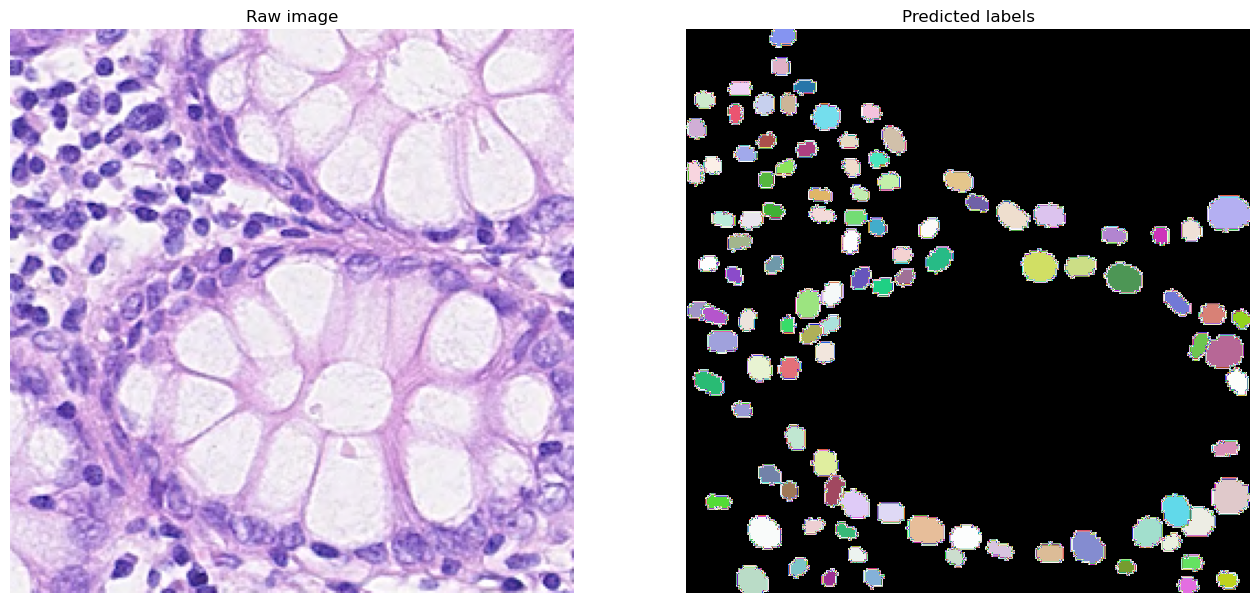

In [6]:
# Plot a few example images
i = 10
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img_array[i], cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(preds[i], cmap=lbl_cmap); plt.axis('off'); plt.title('Predicted labels')
plt.show()

## Extract patches

In [13]:
def extract_square_patches(segmentation_maps, images, margin=10, patch_size=(64, 64)):
    all_patches = []
    patch_info = []  # List to store information about each patch

    for i, (segmentation_map, image) in enumerate(zip(segmentation_maps, images)):
        for cell_id in np.unique(segmentation_map):
            if cell_id == 0:  # Skip background
                continue

            # Find the positions of the current cell
            positions = np.where(segmentation_map == cell_id)
            min_row, min_col = np.min(positions, axis=1)
            max_row, max_col = np.max(positions, axis=1)

            # Determine the size of the square bounding box
            box_size = max(max_row - min_row, max_col - min_col) + margin

            # Calculate the center of the bounding box
            center_row = (max_row + min_row) // 2
            center_col = (max_col + min_col) // 2

            # Determine new min and max rows and columns
            start_row = max(center_row - box_size // 2, 0)
            end_row = min(center_row + box_size // 2, segmentation_map.shape[0])
            start_col = max(center_col - box_size // 2, 0)
            end_col = min(center_col + box_size // 2, segmentation_map.shape[1])

            # Extract the patch from the image
            patch = image[start_row:end_row, start_col:end_col]

            # Resize the patch to the desired size
            resized_patch = cv2.resize(patch, patch_size, interpolation=cv2.INTER_LINEAR)

            # Store the patch and its corresponding information
            all_patches.append(resized_patch)
            patch_info.append({
                'image_index': i,  # Index of the original image
                'cell_id': cell_id,  # Identifier of the cell in the segmentation map
                'segmentation_map': segmentation_map[start_row:end_row, start_col:end_col],  # Segmentation map portion for the patch
                'tl_corner': (start_col, start_row),  # Top-left corner of the patch in the original image
                'patch_size': (end_col - start_col, end_row - start_row),  # Width and Height of the patch
                'is_neutrophil': None  # Placeholder for classification result
            })

    return np.array(all_patches), patch_info

In [14]:
# Get all patches and labels
patches, patch_info = extract_square_patches(preds, img_array)

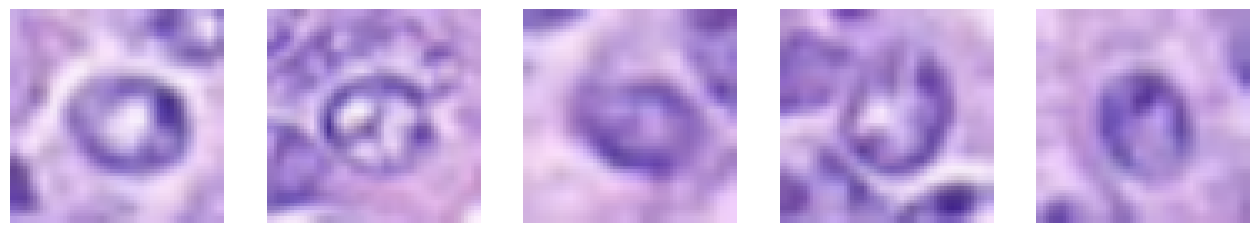

In [16]:
# plot a few patches
plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(patches[i], cmap='gray')
    plt.axis('off')
plt.show()

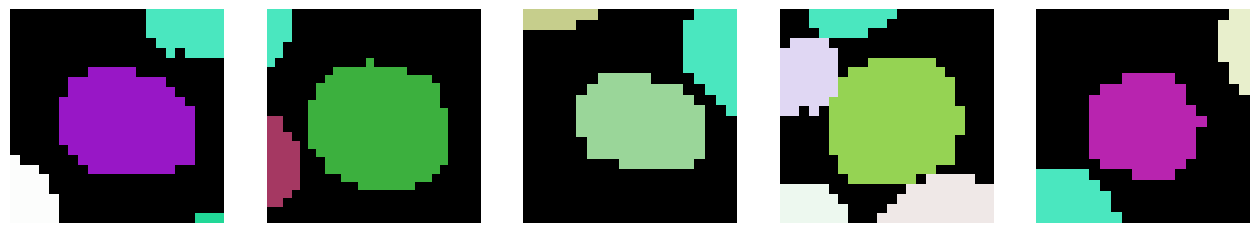

In [60]:
# Plot a few segmentation maps
plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(patch_info[i]['segmentation_map'], cmap=lbl_cmap)
    plt.axis('off')

In [71]:
# Amount of patches
print("Amount of patches:", len(patches))

Amount of patches: 544866


## Run classification

In [18]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet34(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, num_classes)
        self.criterion = torch.nn.BCEWithLogitsLoss()  # Use Binary Cross-Entropy Loss with logits

    def forward(self, x):
        return self.model(x).squeeze(1)  # Use squeeze to remove unnecessary dimensions

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = labels.float()  # Ensure labels are float for BCEWithLogitsLoss
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = labels.float()  # Ensure labels are float for BCEWithLogitsLoss
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        # Configure optimizers and learning rate schedulers
        optimizer = Prodigy(self.parameters(), lr=1.)
        return optimizer

In [19]:
# Load the model
num_classes = 1
model = ImageClassifier(num_classes=num_classes)
model.load_state_dict(torch.load('models/neutrophil_model_1class.pth'))
model.eval()

ImageClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [20]:
threshold = 0.5  # Define your threshold for classification

with torch.no_grad():
    for i, patch in enumerate(patches):
        # Convert the patch to a PyTorch tensor, normalize, add batch dimension, and transfer to the correct device
        patch_tensor = transforms.ToTensor()(patch).unsqueeze(0)
        patch_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(patch_tensor)

        # Predict
        output = model(patch_tensor)
        probability = torch.sigmoid(output)  # Apply sigmoid to convert output to probability
        pred = (probability > threshold).item()  # Convert probability to binary class based on the threshold

        # Update patch_info with the prediction
        patch_info[i]['is_neutrophil'] = pred

In [54]:
neutrophil = []
not_neutrophil = []

for patch in patch_info:
    if patch['is_neutrophil'] == 0:
        neutrophil.append(patch)
    else:
        not_neutrophil.append(patch)

# how many patches are classified as neutrophils
print("Neutrophils:", len(neutrophil))
print("Not Neutrophils:", len(not_neutrophil))

Neutrophils: 4623
Not Neutrophils: 540243


In [21]:
# Save all information such that i dont have to run the model again
import pickle
with open('patch_info.pkl', 'wb') as f:
    pickle.dump(patch_info, f)

In [ ]:
# Load the patch information
with open('patch_info.pkl', 'rb') as f:
    patch_info = pickle.load(f)

## Map classifications to segmentation map